# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

Note:
- Majority of time spent during experimentation right now is spent on building the forest. Meanwhile the queries are actually pretty fast.

In [53]:
import time
import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pytest

from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH

sys.path.append(os.path.abspath("../src"))


def recall(best, approximates, k):
    "Calculates Recall@k for sorted lists of document ids"

    assert len(best) == len(approximates), "must have same number of elements"

    true_set = set(best[:k])
    predicted_set = set(approximates[:k])

    return len(true_set & predicted_set) / k



def chamfer(queries: np.ndarray, vectors: np.ndarray):
        """Takes two sets of vectors and calculates chamfer"""

        # (n, m) matrix of all the pairwise dot products
        dot_products = queries @ vectors.T

        # sum the max value for each query (row)
        chamfer = np.sum(np.max(dot_products, axis=1))
        return chamfer

def timed_score(score_fn, query_vecs, doc_vecs, **kwargs):
    n_q, n_d = len(query_vecs), len(doc_vecs)
    print(f"→ Running {score_fn.__name__} on {n_q} query vectors vs {n_d} doc vectors...")

    start = time.perf_counter()
    score = score_fn(query_vecs, doc_vecs, **kwargs)
    end = time.perf_counter()

    print(f"Time taken: {end - start:.6f} seconds")
    print(f"Vector comparisons (est.): {n_q * n_d:,}\n")

    return score

# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert timed_score(chamfer, A, B) == pytest.approx(1.0)
assert timed_score(chamfer, B, A) == pytest.approx(1 + np.sqrt(.5))
assert timed_score(chamfer, B, C) == pytest.approx(2)
assert timed_score(chamfer, B, B) == pytest.approx(2)
assert timed_score(chamfer, C, C) == pytest.approx(4)

→ Running chamfer on 1 query vectors vs 2 doc vectors...
Time taken: 0.001084 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 1 doc vectors...
Time taken: 0.000020 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 4 doc vectors...
Time taken: 0.000038 seconds
Vector comparisons (est.): 8

→ Running chamfer on 2 query vectors vs 2 doc vectors...
Time taken: 0.000881 seconds
Vector comparisons (est.): 4

→ Running chamfer on 4 query vectors vs 4 doc vectors...
Time taken: 0.000028 seconds
Vector comparisons (est.): 16



In [54]:
# Hyperparameters and constants
n = 10                                # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 15                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)

# Get normalized document and query vectors
data = rng.normal(size=(n, m, d)).astype(np.float32)
data /= np.linalg.norm(data, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

distance = lambda a, b: -np.dot(a, b)


In [55]:
# Constructors for each forest type

def build_simple_lsh(l, k, km):
        single_doc_forests = [LSHForest(RandomHyperplaneLSH(d), l, k, km) for _ in range(n)]
        for doc, forest in enumerate(single_doc_forests):
                forest.batch_insert(data[doc])
        return single_doc_forests


def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(RandomHyperplaneLSH(d), l, k, km)
        multi_doc_forest.batch_insert(data)
        return multi_doc_forest

In [ ]:
# Retrieval Logic

def collect_matches(forests, a):

        matches = np.empty((n, q, d), dtype=np.float32)
        multi = not isinstance(forests, list)
        if multi:
                for i, query in enumerate(queries):
                        results = forests.query(query, a, dist=distance)
                        for document, result in enumerate(results):
                                idx, _ = result[0]
                                matches[document, i] = forests.data[document][idx]
        else:
                for document, forest in enumerate(forests):
                        for i, query in enumerate(queries):
                                idx = forest.query(query, a, dist=distance)[0][0]
                                matches[document, i] = forest.data[idx] 

        return matches

        

def sim_scores(matches: np.ndarray, queries: np.ndarray) -> np.ndarray:
    """
    Dot-product similarity for every document.
    Returns (D,) vector of scores.
    """
    return np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        
def rank_documents(forests, a) -> list[(int, float)]:
        scores = sim_scores(collect_matches(forests, a), queries)
        order  = np.argsort(-scores)
        return order

def best_document(forests, a) -> tuple[float, int]:
    """
    Convenience wrapper that returns only the best matching document.
    """
    scores = sim_scores(collect_matches(forests, a), queries)
    best   = int(np.argmax(scores))
    return float(scores[best]), best

In [57]:
# Baseline

sims = np.array([chamfer(queries, doc_vecs) for doc_vecs in data], dtype=np.float32)
best_doc = int(np.argmax(sims))
best_score = float(sims[best_doc])
print(best_doc, best_score)

true_ranking = np.argsort(-sims)
print(true_ranking[:10])


4 14.170031547546387
[4 6 2 7 0 5 8 3 1 9]


In [60]:
# Experiment logic

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}

defaults = dict(l=l, k=k, km=km, a=a)


def timed(func, *args):
    start = time.perf_counter()
    output = func(*args)
    end = time.perf_counter()
    print(f"{func.__name__} took {end - start:.4f} sec")
    return output

def plot(x, y, xlabel):
    plt.figure()
    plt.plot(x, y, marker='o')
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Similarity Score')
    plt.title(f'Convergence of LSH approximation as {xlabel} grows')
    plt.show()

def plot_similarity_heatmap(query_vecs, doc_vecs, title="Similarity Heatmap"):
    sim_matrix = np.dot(query_vecs, doc_vecs.T)  # shape (q, m)

    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("bwr")  # blue-white-red diverging colormap
    vmax = np.abs(sim_matrix).max()  # ensure center is zero
    plt.imshow(sim_matrix, aspect='auto', cmap=cmap, vmin=-vmax, vmax=vmax)
    plt.colorbar(label='Dot Product Similarity')
    plt.xlabel("Document Vector Index")
    plt.ylabel("Query Vector Index")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def nearest_experiment(variable, values, defaults, build):
        sims, docs = [], []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(parameters['l'], parameters['k'], parameters['km'],)
                sim, doc = timed(best_document, forest, parameters['a'])
                sims.append(sim)
                docs.append(doc)
        print(f"Finished nearest experiment: {variable}")
        return sims, docs
    
def recall_experiment(variable, values, defaults, build, num_items):
        recall_vals = []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(parameters['l'], parameters['k'], parameters['km'],)
                ranking = timed(rank_documents, forest, parameters['a'])
                recall_vals.append(recall(true_ranking, ranking, num_items))
        print(f"Finished recall experiment: {variable}")
        return recall_vals
     
    



Finding best document took 0.0073 sec, 375 vector comparisons (approx)
Finding best document took 0.0150 sec, 375 vector comparisons (approx)
Finding best document took 0.0224 sec, 375 vector comparisons (approx)
Finding best document took 0.0354 sec, 375 vector comparisons (approx)
Finding best document took 0.0593 sec, 375 vector comparisons (approx)
Finished experiment: l


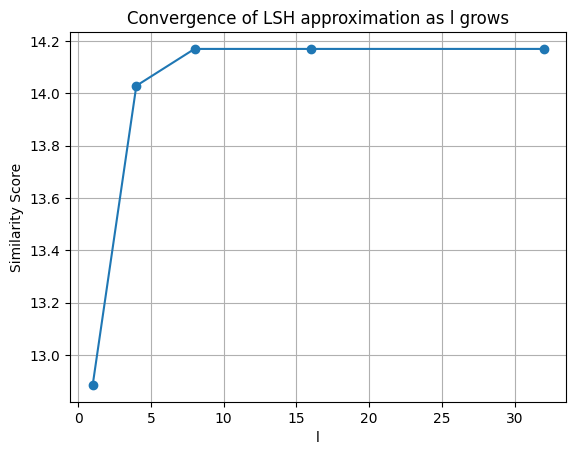

Best l = 8 → doc #4


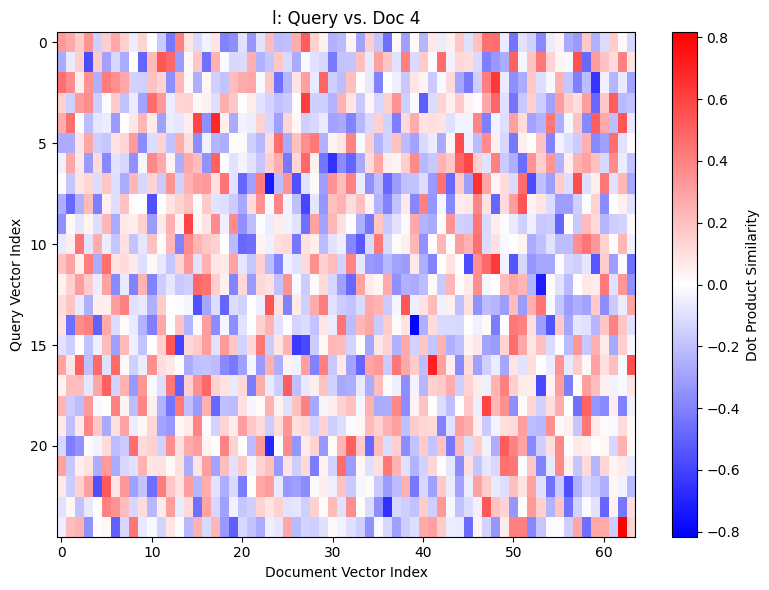

Finding best document took 0.0231 sec, 375 vector comparisons (approx)
Finding best document took 0.0242 sec, 375 vector comparisons (approx)
Finding best document took 0.0252 sec, 375 vector comparisons (approx)
Finding best document took 0.0277 sec, 375 vector comparisons (approx)
Finding best document took 0.0283 sec, 375 vector comparisons (approx)
Finished experiment: k


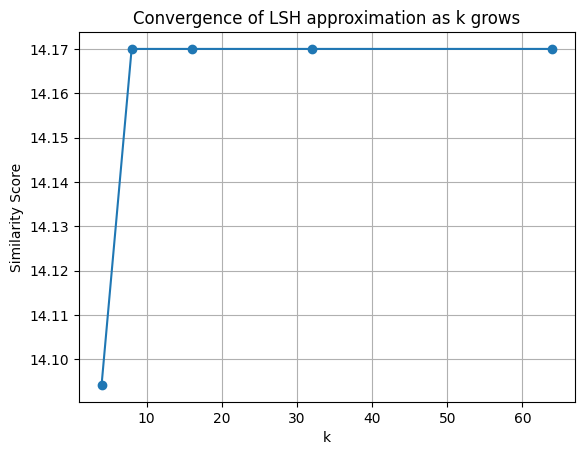

Best k = 8 → doc #4


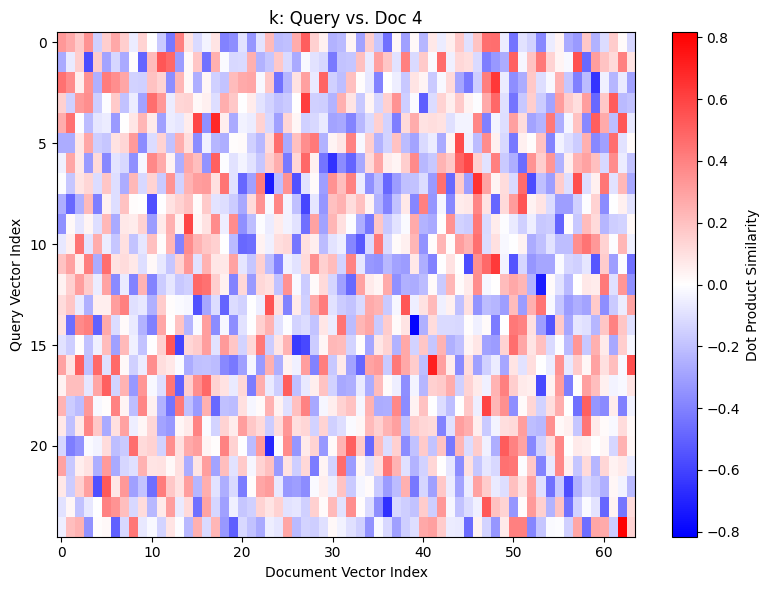

Finding best document took 0.0252 sec, 375 vector comparisons (approx)
Finding best document took 0.0258 sec, 375 vector comparisons (approx)
Finding best document took 0.0273 sec, 375 vector comparisons (approx)
Finding best document took 0.0254 sec, 375 vector comparisons (approx)
Finding best document took 0.0268 sec, 375 vector comparisons (approx)
Finished experiment: km


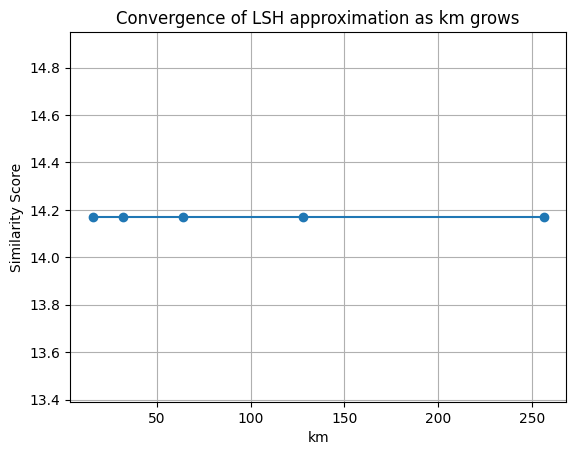

Best km = 16 → doc #4


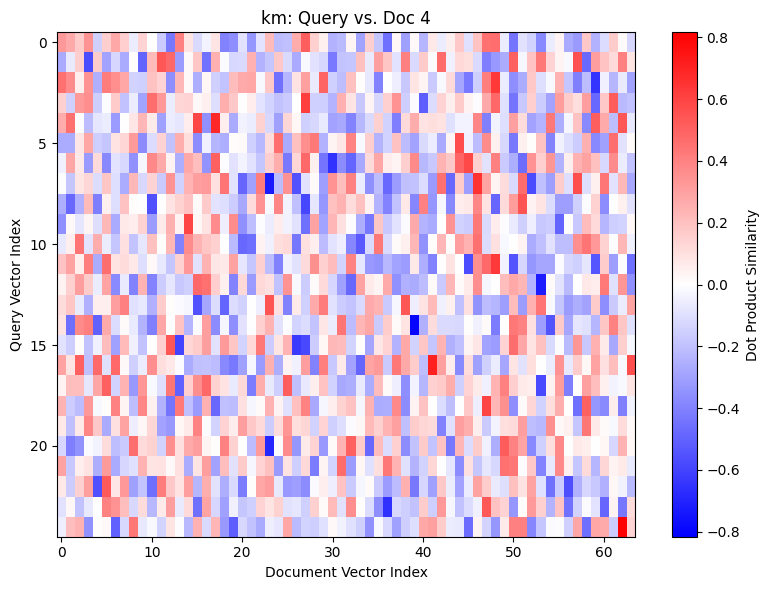

Finding best document took 0.0271 sec, 25 vector comparisons (approx)
Finding best document took 0.0271 sec, 100 vector comparisons (approx)
Finding best document took 0.0272 sec, 200 vector comparisons (approx)
Finding best document took 0.0257 sec, 400 vector comparisons (approx)
Finding best document took 0.0245 sec, 800 vector comparisons (approx)
Finished experiment: a


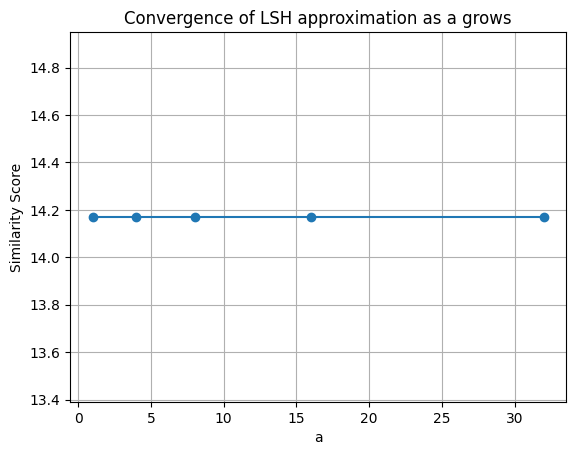

Best a = 1 → doc #4


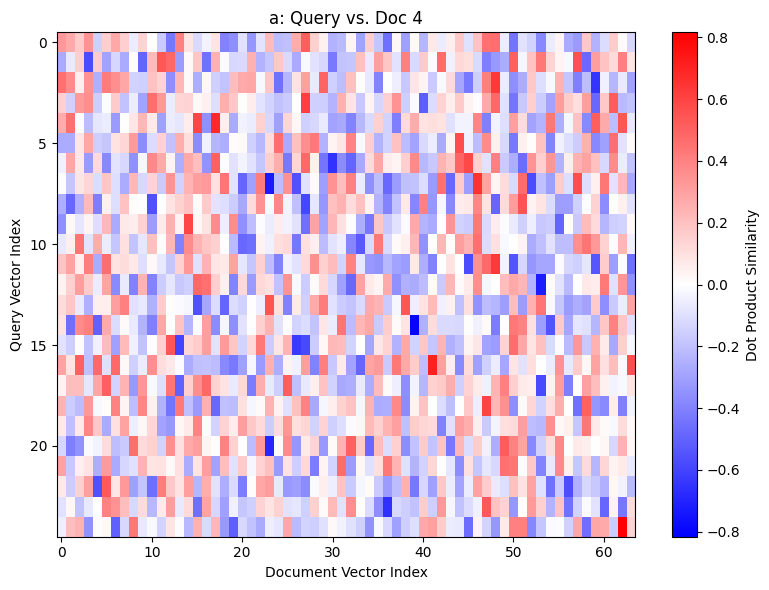

In [ ]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = nearest_experiment(var, vals, defaults, build_simple_lsh)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, data[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")


best_document took 0.0042 sec
best_document took 0.0064 sec
best_document took 0.0100 sec
best_document took 0.0134 sec
best_document took 0.0221 sec
Finished nearest experiment: l
best_document took 0.0108 sec
best_document took 0.0103 sec
best_document took 0.0095 sec
best_document took 0.0115 sec
best_document took 0.0156 sec
Finished nearest experiment: k
best_document took 0.0106 sec
best_document took 0.0094 sec
best_document took 0.0098 sec
best_document took 0.0153 sec
best_document took 0.0093 sec
Finished nearest experiment: km
best_document took 0.0041 sec
best_document took 0.0062 sec
best_document took 0.0076 sec
best_document took 0.0105 sec
best_document took 0.0158 sec
Finished nearest experiment: a


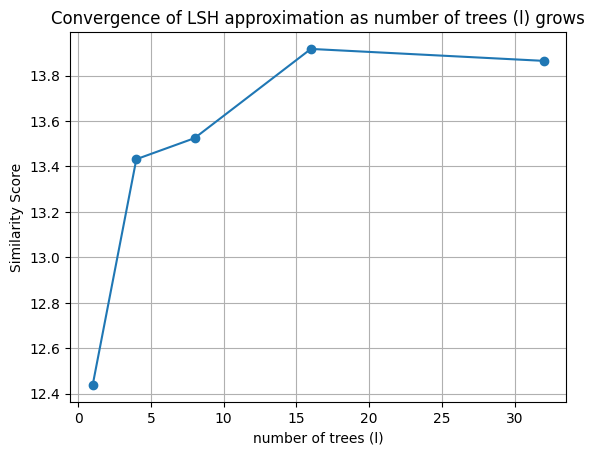

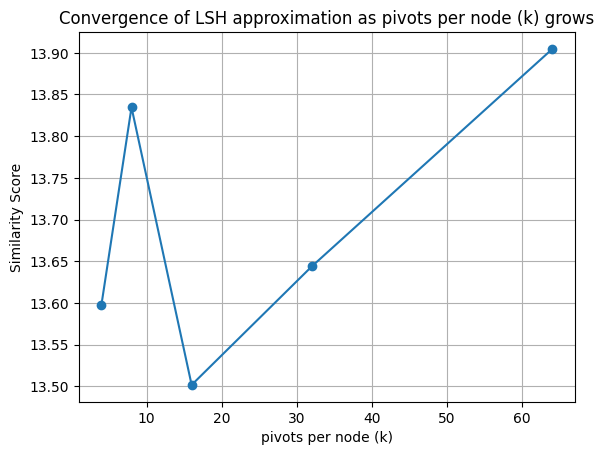

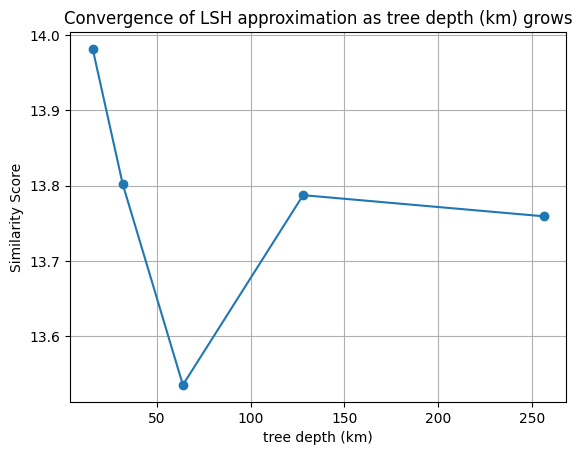

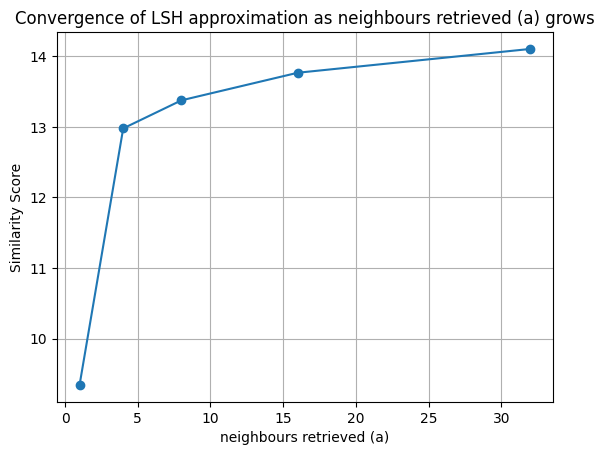

In [59]:

# Evaluate multi-doc
results = {var: nearest_experiment(var, vals, defaults, build_multidoc_lsh) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')


In [ ]:
# Evaluate multi-doc recall
results = {var: recall_experiment(var, vals, defaults, build_multidoc_lsh, 3) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'],  'number of trees (l)')
plot(experiments['k'],  results['k'],  'pivots per node (k)')
plot(experiments['km'], results['km'], 'tree depth (km)')
plot(experiments['a'],  results['a'],  'neighbours retrieved (a)')

rank_documents took 0.0713 sec
